In [3]:
import numpy as np
import pandas as pd
import random
import fnmatch
import os
import h5py

import tensorflow as tf
print('TF file:',tf.__file__)

path = '/home/jorge/data/kaggle/statefarm/'

('TF file:', '/usr/local/lib/python2.7/dist-packages/tensorflow/__init__.pyc')


In [4]:
#Use the pretrained model
path_model = '/home/jorge/data/pretrained_models/tensorflow/inception/'
#path_model = '/Users/jorge/tensorflow/tensorflow/models/image/imagenet'

#Create graph
with tf.gfile.FastGFile(os.path.join(path_model, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')


In [50]:
def evaluate_inception(batch_img):
    
    mixed2_conv = np.empty([len(batch_img), 35, 35, 288], dtype=np.float32)
        
    mixed8_conv = np.empty([len(batch_img), 8, 8, 1280])
    mixed8_tensor_values = np.empty([len(batch_img), 1280])
    
    mixed9_conv = np.empty([len(batch_img), 8, 8, 2048])
    mixed9_tensor_values = np.empty([len(batch_img), 2048])
    
    mixed10_conv = np.empty([len(batch_img), 8, 8, 2048])
    incepcion_pool3_values = np.empty([len(batch_img), 2048])

    predictions = np.empty([len(batch_img),1008])
    image_list = []

    #Extract intermediate data from the jpg file
    with tf.Session() as sess:
        #softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')
        softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')

        mixed2_tensor = sess.graph.get_tensor_by_name('mixed_2/join:0')

        mixed8_tensor = sess.graph.get_tensor_by_name('mixed_8/join:0')

        mixed9_tensor = sess.graph.get_tensor_by_name('mixed_9/join:0')

        mixed10_tensor = sess.graph.get_tensor_by_name('mixed_10/join:0')
        pool3_tensor = sess.graph.get_tensor_by_name('pool_3/_reshape:0')
        #print pool3_tensor.get_shape() 
        #print pool3_tensor[:,0].eval()

        for i, img in enumerate(batch_img):
            image_list += [img.split('/')[-1]]

            image_data = tf.gfile.FastGFile(img,'rb').read()
            
            mixed2_tensor_value = sess.run(mixed2_tensor, {'DecodeJpeg/contents:0': image_data})
            mixed2_conv[i] = mixed2_tensor_value[0,:,:,:]
            
            mixed8_tensor_value = sess.run(mixed8_tensor, {'mixed_2/join:0': mixed2_tensor_value})
            mixed8_conv[i] = mixed8_tensor_value[0,:,:,:]
            mixed8_tensor_values[i] = np.max(np.reshape(mixed8_tensor_value[0,:,:,:],[8*8,1280]),axis=0)

            mixed9_tensor_value = sess.run(mixed9_tensor, {'mixed_8/join:0': mixed8_tensor_value})
            mixed9_conv[i] = mixed9_tensor_value[0,:,:,:]
            mixed9_tensor_values[i] = np.max(np.reshape(mixed9_tensor_value[0,:,:,:],[8*8,2048]),axis=0)

            mixed10_tensor_value = sess.run(mixed10_tensor, {'mixed_9/join:0': mixed9_tensor_value})
            mixed10_conv[i] = mixed10_tensor_value[0,:,:,:]
            
            incepcion_pool3_value = sess.run(pool3_tensor,{'mixed_9/join:0': mixed9_tensor_value})
            incepcion_pool3_values[i] = incepcion_pool3_value[0,:]

            predictions[i] = sess.run(softmax_tensor,{'pool_3/_reshape:0': incepcion_pool3_value})[0,:]
            if i % 500 == 0:
                print('Processed', i, 'images from ',len(batch_img))
    return image_list, mixed2_conv, mixed8_conv, mixed8_tensor_values, mixed9_conv, mixed9_tensor_values, mixed10_conv, incepcion_pool3_values, predictions
        

In [51]:
#Test
image_list, conv2, conv8, layer8, conv9, layer9, conv10, layer10, predictions = evaluate_inception(['/home/jorge/data/kaggle/statefarm//sources/imgs/train/c2/img_48527.jpg',
                                                          '/home/jorge/data/kaggle/statefarm//sources/imgs/train/c2/img_2782.jpg'])
print('layer8: ', layer8[0])
print('layer9: ', layer9[0])
print('layer10: ', layer10[0])
print('predictions: ', predictions[0])
print('Image list: ', image_list)

('Processed', 0, 'images from ', 2)
('layer8: ', array([ 1.35979533,  2.66526389,  2.13184237, ...,  1.7782408 ,
        1.33178174,  1.58746636]))
('layer9: ', array([ 0.43170908,  1.72573614,  1.11879694, ...,  0.24815984,
        0.18799247,  0.58042067]))
('layer10: ', array([ 0.31927314,  0.79435837,  0.52067602, ...,  0.55574703,
        0.06320436,  0.27538911]))
('predictions: ', array([  7.62325217e-05,   3.40247243e-05,   1.40678909e-04, ...,
         7.62327400e-05,   7.62314376e-05,   7.62314376e-05]))
('Image list: ', ['img_48527.jpg', 'img_2782.jpg'])


In [15]:
def evaluate_inception_hdf5(batch_img, hdf5_file, batch_size=64):
    
    if os.path.isfile(hdf5_file):
        os.remove(hdf5_file)
        
    with h5py.File(hdf5_file, "a") as hdf5_f:
        
        mixed2_conv=[]
        mixed4_conv=[]
        mixed6_conv=[]
        mixed8_conv=[]
        mixed9_conv=[]
        mixed10_conv=[]
        predictions=[]

        image_list = []

        #Extract intermediate data from the jpg file
        with tf.Session() as sess:
            
            softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')

            mixed2_tensor = sess.graph.get_tensor_by_name('mixed_2/join:0')

            mixed4_tensor = sess.graph.get_tensor_by_name('mixed_4/join:0')
            
            mixed6_tensor = sess.graph.get_tensor_by_name('mixed_6/join:0')

            mixed8_tensor = sess.graph.get_tensor_by_name('mixed_8/join:0')

            mixed9_tensor = sess.graph.get_tensor_by_name('mixed_9/join:0')

            mixed10_tensor = sess.graph.get_tensor_by_name('mixed_10/join:0')
            
            batch_step=0
            for i, img in enumerate(batch_img):
                
                if (i>0 and i%batch_size==0):
                    #Create conv2
                    hdf5_f.create_dataset("conv2_"+str(batch_step), data = np.array(mixed2_conv, dtype=np.float32))
                    mixed2_conv=[]

                    #Create conv4
                    hdf5_f.create_dataset("conv4_"+str(batch_step), data = np.array(mixed4_conv, dtype=np.float32))
                    mixed4_conv=[]
                    
                    #Create conv6
                    hdf5_f.create_dataset("conv6_"+str(batch_step), data = np.array(mixed6_conv, dtype=np.float32))
                    mixed6_conv=[]
                    
                    #Create conv8
                    hdf5_f.create_dataset("conv8_"+str(batch_step), data = np.array(mixed8_conv, dtype=np.float32))
                    mixed8_conv=[]

                    #Create conv9
                    hdf5_f.create_dataset("conv9_"+str(batch_step), data = np.array(mixed9_conv, dtype=np.float32))
                    mixed9_conv=[]
                    
                    #Create conv10
                    hdf5_f.create_dataset("conv10_"+str(batch_step), data = np.array(mixed10_conv, dtype=np.float32))
                    mixed10_conv=[]
                    
                    #Create conv10
                    hdf5_f.create_dataset("predictions_"+str(batch_step), data = np.array(predictions, dtype=np.float32))
                    predictions=[]
                    
                    batch_step += 1 

                    
                image_list += [img.split('/')[-1]]

                image_data = tf.gfile.FastGFile(img,'rb').read()

                mixed2_tensor_value = sess.run(mixed2_tensor, {'DecodeJpeg/contents:0': image_data})
                mixed2_conv += [mixed2_tensor_value[0,:,:,:]]

                mixed4_tensor_value = sess.run(mixed4_tensor, {'mixed_2/join:0': mixed2_tensor_value})
                mixed4_conv += [mixed4_tensor_value[0,:,:,:]]

                mixed6_tensor_value = sess.run(mixed6_tensor, {'mixed_4/join:0': mixed4_tensor_value})
                mixed6_conv += [mixed6_tensor_value[0,:,:,:]]

                mixed8_tensor_value = sess.run(mixed8_tensor, {'mixed_6/join:0': mixed6_tensor_value})
                mixed8_conv += [mixed8_tensor_value[0,:,:,:]]
                
                mixed9_tensor_value = sess.run(mixed9_tensor, {'mixed_8/join:0': mixed8_tensor_value})
                mixed9_conv += [mixed9_tensor_value[0,:,:,:]]
                
                mixed10_tensor_value = sess.run(mixed10_tensor, {'mixed_9/join:0': mixed9_tensor_value})
                mixed10_conv += [mixed10_tensor_value[0,:,:,:]]

                predictions += [sess.run(softmax_tensor,{'mixed_10/join:0': mixed10_tensor_value})[0,:]]

                
                if i % 500 == 0:
                    print('Processed', i, 'images from ',len(batch_img))
                    
            hdf5_f.create_dataset("image_list", data = image_list)
            hdf5_f.create_dataset("num_batches", data = batch_step) 
                    
        

In [16]:
#Save features as np arrays
def create_inception_features_hdf5(dir_images, dataset_type='trn', filter_image_type='*.jpg'):
    # List of images
    batch_img = []
    for root, dirnames, filenames in os.walk(dir_images):
        for filename in fnmatch.filter(filenames, filter_image_type):
            batch_img.append(os.path.join(root, filename))
    batch_img = sorted(batch_img)
            
    # Evaluate inception
    evaluate_inception_hdf5(batch_img, path + "data/feat_inception/"+dataset_type+".hdf5")
    
    print('Done creating numpy features for', dir_images)

# Train
create_inception_features_hdf5(path + 'data/imgs_trnval/train/',  dataset_type='trn')
create_inception_features_hdf5(path + 'data/imgs_trnval/val/',  dataset_type='tst')




('Processed', 0, 'images from ', 19654)
('Processed', 500, 'images from ', 19654)
('Processed', 1000, 'images from ', 19654)
('Processed', 1500, 'images from ', 19654)
('Processed', 2000, 'images from ', 19654)
('Processed', 2500, 'images from ', 19654)
('Processed', 3000, 'images from ', 19654)
('Processed', 3500, 'images from ', 19654)
('Processed', 4000, 'images from ', 19654)
('Processed', 4500, 'images from ', 19654)
('Processed', 5000, 'images from ', 19654)
('Processed', 5500, 'images from ', 19654)
('Processed', 6000, 'images from ', 19654)
('Processed', 6500, 'images from ', 19654)
('Processed', 7000, 'images from ', 19654)
('Processed', 7500, 'images from ', 19654)
('Processed', 8000, 'images from ', 19654)
('Processed', 8500, 'images from ', 19654)
('Processed', 9000, 'images from ', 19654)
('Processed', 9500, 'images from ', 19654)
('Processed', 10000, 'images from ', 19654)
('Processed', 10500, 'images from ', 19654)
('Processed', 11000, 'images from ', 19654)
('Processed'

In [35]:
#Check hd5 file
with h5py.File(path + "data/feat_inception/trn.hdf5", "r") as f:
    print(f.keys())
    num_batches = np.copy(f['num_batches'])
    
    print(num_batches)
    print(f['image_list'][:10])
    #X = hdf5_f["X"]

[u'conv2_0', u'conv2_1', u'conv2_2', u'conv2_3', u'conv2_4', u'conv2_5', u'conv2_6', u'conv2_7', u'image_list', u'num_batches']
8
['img_100026.jpg' 'img_10003.jpg' 'img_100050.jpg' 'img_100074.jpg'
 'img_100145.jpg' 'img_100191.jpg' 'img_100257.jpg' 'img_100312.jpg'
 'img_100337.jpg' 'img_100456.jpg']


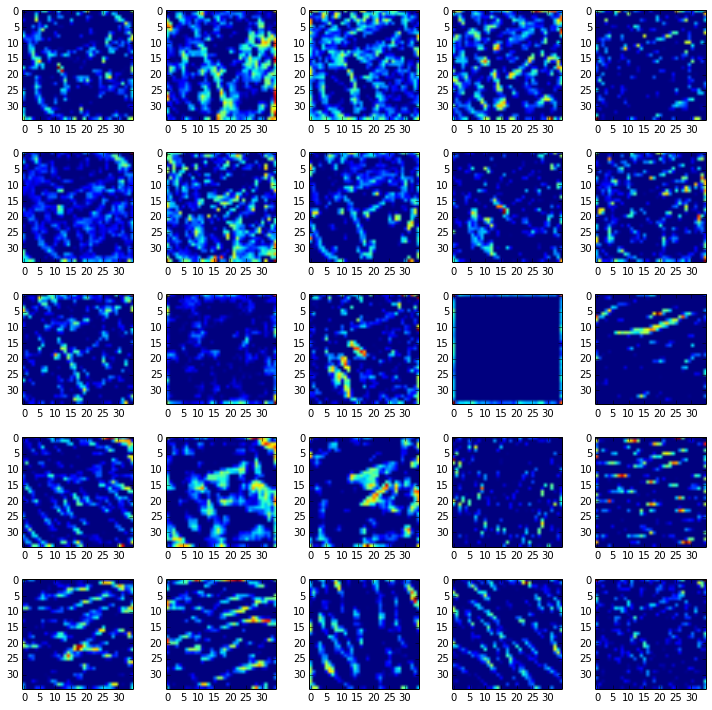

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)        # size of images

fig = plt.figure()
for i in xrange(25):
    a = fig.add_subplot(5,5,i)
    #a.set_title('Target: ' + str(np.argmax(mnist.train.labels[i])))
    fig.tight_layout()
    plt.imshow(conv2[0,:,:,i+50])

    
    

In [ ]:
#Save features as np arrays
def create_inception_features_array(dir_images, dataset_type='trn', filter_image_type='*.jpg'):
    # List of images
    batch_img = []
    for root, dirnames, filenames in os.walk(dir_images):
        for filename in fnmatch.filter(filenames, filter_image_type):
            batch_img.append(os.path.join(root, filename))
            
    # Evaluate inception
    image_list, conv2, conv8, layer8, conv9, layer9, conv10, layer10, predictions = evaluate_inception(batch_img)

    # Order by image name
    pd_list =  pd.DataFrame(image_list, columns=['img'])
    order = pd_list.sort('img').index
    
    np.save(path + "data/feat_inception/conv2."  + dataset_type, conv2[order])
    np.save(path + "data/feat_inception/conv8."  + dataset_type, conv8[order])
    np.save(path + "data/feat_inception/conv9."  + dataset_type, conv9[order])
    np.save(path + "data/feat_inception/conv10." + dataset_type, conv10[order])
    
    print('Done creating numpy features for', dir_images)


# Train
create_inception_features_array(path + 'data/imgs_trnval/train/',  dataset_type='trn')

# Test
create_inception_features_array(path + 'data/imgs_trnval/val/',  dataset_type='tst')

# score
create_inception_features_array(path + 'sources/imgs/test/',  dataset_type='sco')

('Processed', 0, 'images from ', 19654)
('Processed', 500, 'images from ', 19654)
('Processed', 1000, 'images from ', 19654)
('Processed', 1500, 'images from ', 19654)
('Processed', 2000, 'images from ', 19654)
('Processed', 2500, 'images from ', 19654)
('Processed', 3000, 'images from ', 19654)
('Processed', 3500, 'images from ', 19654)
('Processed', 4000, 'images from ', 19654)
('Processed', 4500, 'images from ', 19654)
('Processed', 5000, 'images from ', 19654)
('Processed', 5500, 'images from ', 19654)
('Processed', 6000, 'images from ', 19654)
('Processed', 6500, 'images from ', 19654)
('Processed', 7000, 'images from ', 19654)
('Processed', 7500, 'images from ', 19654)
('Processed', 8000, 'images from ', 19654)
('Processed', 8500, 'images from ', 19654)
('Processed', 9000, 'images from ', 19654)
('Processed', 9500, 'images from ', 19654)
('Processed', 10000, 'images from ', 19654)
('Processed', 10500, 'images from ', 19654)
('Processed', 11000, 'images from ', 19654)
('Processed'

In [8]:
#Save features as csv
def create_inception_features(dir_images, dataset_type='trn', filter_image_type='*.jpg'):
    # List of images
    batch_img = []
    for root, dirnames, filenames in os.walk(dir_images):
        for filename in fnmatch.filter(filenames, filter_image_type):
            batch_img.append(os.path.join(root, filename))
            
    # Evaluate inception
    image_list, layer8, layer9, layer10, predictions = evaluate_inception(batch_img)

    #Generate csv files for features
    layer8_cols =      ['incepcion_ly8_'  + str(i) for i in range(layer8.shape[1])]
    df = pd.DataFrame(layer8, columns=layer8_cols, index=image_list)
    df.sort_index(inplace=True)
    df.to_csv(path + "data/feat_inception/layer8.csv." + dataset_type)
    
    layer9_cols =      ['incepcion_ly9_'  + str(i) for i in range(layer9.shape[1])]
    df = pd.DataFrame(layer9, columns=layer9_cols, index=image_list)
    df.sort_index(inplace=True)
    df.to_csv(path + "data/feat_inception/layer9.csv." + dataset_type)
    
    layer10_cols =     ['incepcion_ly10_' + str(i) for i in range(layer10.shape[1])]
    df = pd.DataFrame(layer10, columns=layer10_cols, index=image_list)
    df.sort_index(inplace=True)
    df.to_csv(path + "data/feat_inception/layer10.csv." + dataset_type)
    
    predictions_cols = ['incepcion_pred_' + str(i) for i in range(predictions.shape[1])]
    df = pd.DataFrame(predictions, columns=predictions_cols, index=image_list)
    df.sort_index(inplace=True)
    df.to_csv(path + "data/feat_inception/predictions.csv." + dataset_type)

    print('Done creating features for', dir_images)


# Train
#create_inception_features(path + '/data/imgs_trnval/train/',  dataset_type='trn')

# Test
create_inception_features(path + '/data/imgs_trnval/val/',  dataset_type='tst')

# score
#create_inception_features(path + '/sources/imgs/score',  dataset_type='sco')

('Processed', 0, 'images from ', 2770)
('Processed', 500, 'images from ', 2770)
('Processed', 1000, 'images from ', 2770)
('Processed', 1500, 'images from ', 2770)
('Processed', 2000, 'images from ', 2770)
('Processed', 2500, 'images from ', 2770)
('Done creating features for', '/home/jorge/data/kaggle/statefarm//data/imgs_trnval/val/')


In [5]:
#List all layers of a net
with tf.Session() as sess:
    for op in sess.graph.get_operations():
        print(op.name)
        print(op.values())

DecodeJpeg/contents
(<tf.Tensor 'DecodeJpeg/contents:0' shape=() dtype=string>,)
DecodeJpeg
(<tf.Tensor 'DecodeJpeg:0' shape=(?, ?, 3) dtype=uint8>,)
Cast
(<tf.Tensor 'Cast:0' shape=(?, ?, 3) dtype=float32>,)
ExpandDims/dim
(<tf.Tensor 'ExpandDims/dim:0' shape=(1,) dtype=int32>,)
ExpandDims
(<tf.Tensor 'ExpandDims:0' shape=(1, ?, ?, 3) dtype=float32>,)
ResizeBilinear/size
(<tf.Tensor 'ResizeBilinear/size:0' shape=(2,) dtype=int32>,)
ResizeBilinear
(<tf.Tensor 'ResizeBilinear:0' shape=(1, 299, 299, 3) dtype=float32>,)
Sub/y
(<tf.Tensor 'Sub/y:0' shape=() dtype=float32>,)
Sub
(<tf.Tensor 'Sub:0' shape=(1, 299, 299, 3) dtype=float32>,)
Mul/y
(<tf.Tensor 'Mul/y:0' shape=() dtype=float32>,)
Mul
(<tf.Tensor 'Mul:0' shape=(1, 299, 299, 3) dtype=float32>,)
conv/conv2d_params
(<tf.Tensor 'conv/conv2d_params:0' shape=(3, 3, 3, 32) dtype=float32>,)
conv/Conv2D
(<tf.Tensor 'conv/Conv2D:0' shape=(1, 149, 149, 32) dtype=float32>,)
conv/batchnorm/beta
(<tf.Tensor 'conv/batchnorm/beta:0' shape=(32,) d

In [9]:
#Image data
image = os.path.join(path_model, 'cropped_panda.jpg')
image_data = tf.gfile.FastGFile(image, 'rb').read()


In [10]:
#Generate predictios from the jpg file
with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    predictions = sess.run(softmax_tensor,
                           {'DecodeJpeg/contents:0': image_data})
predictions = np.squeeze(predictions)

print predictions

[[  1.00235826e-04   2.51057325e-04   7.98699330e-05 ...,   1.00235244e-04
    1.00236299e-04   1.00236299e-04]]


In [17]:
class NodeLookup(object):
  """Converts integer node ID's to human readable labels."""

  def __init__(self,
               label_lookup_path=None,
               uid_lookup_path=None):
    if not label_lookup_path:
      label_lookup_path = os.path.join(
          path_model, 'imagenet_2012_challenge_label_map_proto.pbtxt')
    if not uid_lookup_path:
      uid_lookup_path = os.path.join(
          path_model, 'imagenet_synset_to_human_label_map.txt')
    self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

    
  def load(self, label_lookup_path, uid_lookup_path):
    """Loads a human readable English name for each softmax node.

    Args:
      label_lookup_path: string UID to integer node ID.
      uid_lookup_path: string UID to human-readable string.

    Returns:
      dict from integer node ID to human-readable string.
    """
    if not tf.gfile.Exists(uid_lookup_path):
      tf.logging.fatal('File does not exist %s', uid_lookup_path)
    if not tf.gfile.Exists(label_lookup_path):
      tf.logging.fatal('File does not exist %s', label_lookup_path)

    # Loads mapping from string UID to human-readable string
    proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
    uid_to_human = {}
    p = re.compile(r'[n\d]*[ \S,]*')
    for line in proto_as_ascii_lines:
      parsed_items = p.findall(line)
      uid = parsed_items[0]
      human_string = parsed_items[2]
      uid_to_human[uid] = human_string

    # Loads mapping from string UID to integer node ID.
    node_id_to_uid = {}
    proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
    for line in proto_as_ascii:
      if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
      if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

    # Loads the final mapping of integer node ID to human-readable string
    node_id_to_name = {}
    for key, val in node_id_to_uid.items():
      if val not in uid_to_human:
        tf.logging.fatal('Failed to locate: %s', val)
      name = uid_to_human[val]
      node_id_to_name[key] = name

    return node_id_to_name


  def id_to_string(self, node_id):
    if node_id not in self.node_lookup:
      return ''
    return self.node_lookup[node_id]


In [18]:
# Creates node ID --> English string lookup.
node_lookup = NodeLookup()

top_k = predictions.argsort()[-5:][::-1]
for node_id in top_k:
    human_string = node_lookup.id_to_string(node_id)
    score = predictions[node_id]
    print('%s (score = %.5f)' % (human_string, score))

giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca (score = 0.89233)
indri, indris, Indri indri, Indri brevicaudatus (score = 0.00859)
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens (score = 0.00264)
custard apple (score = 0.00141)
earthstar (score = 0.00107)
